In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action="ignore", category=RuntimeWarning)
from IPython.display import HTML
import random

def toggle_code(text_1="Show code", text_2="Hide code"):
    
    rand = 'id'+str(random.randint(1,2**64))
    
    html = """
        <script>
            function code_toggle_{random}() {{
                var element = $('#{random}').parent().parent().parent().parent().parent().find('div.input')
                element.toggle()
                if(element.is(":hidden"))
                    $('#{random}').text("{text_1}")
                else
                    $('#{random}').text("{text_2}")
           }}
            
            $(document).ready(function() {{
                code_toggle_{random}();
                $('#{random}').parent().parent().find('div.prompt.output_prompt').text("")
            }})
        </script>

        <a id="{random}" style="cursor: pointer;" onclick="javascript:code_toggle_{random}()">{text_1}</a>
    """.format(random = rand, text_1 = text_1, text_2=text_2)

    return HTML(html)


toggle_code()

<h1 style="color: #fff;"> </h1>

<h1 style="color:#8B0000; text-align:center; font-size:65px; text-decoration:underline overline;"> K-bMOM</h1>

<h1> This notebook has been done during summer 2019 by Genetay Edoaurd en Velut Dorian. The concepts shown here are very relevant to understand KbMOM but the notations have evolved in the last version of the package. This notebook is very good for those that want to understand want happens step per step inside the KbMOM class. Marginal update were done on 26 august 2022.

<h2 style="text-decoration:underline; font-size:35px;">Table of contents</h2>

> ### A. <a style="font-size:18px;cursor:pointer;color:#666" href='#-Context-and-bibliography'>Context and bibliography</a>  
> ### B. <a style="font-size:18px;cursor:pointer;color:#666" href='#-How-K-bMOM-works'>How K-bMOM works</a> 
>> #### 1. <a style="font-size:15px;cursor:pointer;color:#666" href='#1.-Initialization'> Initialization</a> 
>> #### 2. <a style="font-size:15px;cursor:pointer;color:#666" href="#2.-How-to-choose-$B$-and-$S$"> How to choose $B$ and $S$</a> 
>> #### 3. <a style="font-size:15px;cursor:pointer;color:#666" href="#3.-Iteration"> Iteration</a>

> ### C. <a style="font-size:18px;cursor:pointer;color:#666;" href='#Use-of-K-bMOM'>Use of K-bMOM</a> 
>> #### 1. <a style="font-size:15px;cursor:pointer;color:#666" href="#Launch-KbMOM"> Launch K-bMOM</a>
>> #### 2. <a style="font-size:15px;cursor:pointer;color:#666" href="#Review-all-information-in-K-bMOM-output"> Review all information in output</a>
>>> ##### - <a style="font-size:15px;cursor:pointer;color:#666" href="#centroids"> centroids</a>
>>> ##### - <a style="font-size:15px;cursor:pointer;color:#666" href="#labels"> labels</a>
>>> ##### - <a style="font-size:15px;cursor:pointer;color:#666" href="#id_Qblock_init"> id_Qblock_init</a>
>>> ##### - <a style="font-size:15px;cursor:pointer;color:#666" href="#convergence"> convergence</a>
>>> ##### - <a style="font-size:15px;cursor:pointer;color:#666" href="#scores"> scores</a>
>>> ##### - <a style="font-size:15px;cursor:pointer;color:#666" href="#risk"> risk</a>
>>> ##### - <a style="font-size:15px;cursor:pointer;color:#666" href="#Qb_centers"> Qb_centers</a>
>>> ##### - <a style="font-size:15px;cursor:pointer;color:#666" href="#B"> B</a>
>>> ##### - <a style="font-size:15px;cursor:pointer;color:#666" href="#t"> t</a>

<h2 id="-Context-and-bibliography" style="text-decoration:underline; font-size:30px;"> Context and bibliography</h2>

<h9>

K-bMOM is an algorithm that were first introduced by SAUMARD Adrien, BRUNET-SAUMARD Camille and GENETAY Edouard in februar 2020 in this article: https://arxiv.org/abs/2002.03899

K-bMOM is a clustering algorithm inspired from both K-means and Median-Of-Means (MOM). These two algorithms have advantages whose K-bMOM benefits from: on the one hand, Kmeans is an unsupervised clustering algorithm. On the other hand, it has been recently proved (2015) that MOM is a way better mean operator than the empirical mean because it is robust to outliers (it has also a better convergence rate). As a result, K-bMOM is indeed a robust and unsupervised clustering algorithm. We will describe K-bMOM in the next section. We are going to give in the following paragraphs some context clues.

In principle, K-means is a clustering algorithm that clusterizes vector data in $\mathbb{R}^p$. More precisely, K-means searches for K points $\left( c_1,c_2,...,c_K\right) $ (called centroids) that minimize this quantity $\text{Crit} := \frac{1}{n} \sum_{i=1}^{n} \underset{1\leq j \leq K}{\min} || x_i - c_j||^2$.

Since essence of clustering is mostly the search for the "most relevant" summary of the data, K-means often fails to find the most relevant centroids. That is especially due to the criterion $\text{Crit}$. The optimization of this criterion leads to centroids that are, geometrically speaking, the "most relevant", and even if the geometrical optimum sometimes coincides with what one calls the "most relevant summary of the data", it often does not.

A solution to this issue could come from the use of a better "mean operator" than the "empirical mean" in the criterion $\text{Crit}$. What is called "empirical mean" is namely to sum a bunch of data and to divide the result by the number of elements one has summed up (an example is given in the next paragraph; formally speaking, it is this type of operation: $ \frac{1}{n} \sum_{i=1}^{n}... $). Consequently, the recent theoretical discoveries about "estimating the mean-value of a probability distribution", such as the work about MOM, made K-bMOM possible. Let us explain a few things about some properties of "estimating the mean-value of a probability distribution".

The "empirical mean" of $n$ observations $\left(x_1,x_2,...x_n \right)$ of a random phenomenon is $\frac{1}{n} \sum_{i=1}^{n}x_i$. It is the most basic statistic that every one knows.
_For example: you take the size (in cm) of every close collegues of yours: $\left\{ 168,166,191,160,179 \right\}$. Then divide by the amount of data, $5$, and you get an average size of $ 1.728$ cm (the empirical mean of the observed sizes is 172.8 cm)._ The empirical mean has been studied by mathematician since 18th century:
* Abraham De Moivre found in 1738 that empirical mean gets closer and closer of the mean of a Bernoulli distribution as the number of observation grows.
* After that, Pierre-Simon De Laplace proved in 1809 the first version of the central limit theorem that concerns a property of the empirical mean
* One should wait the work of Alexander Khinchin published in 1929 to obtain a fully general theorem called "weak law of large numbers" (https://www.math.drexel.edu/~tolya/methodofmoments.pdf). This theorem proves that the empirical mean converges in probability to the mean-value of any random phenomenon as the number of observation increases.
* But the endavour for a better understanding of empirical mean continued and Catoni proved in 2015 that the empirical mean suffers from a slow convergence rate without further assumptions on the observed phenomenon. He proved indeed that there exists some random phenomenon with a mean-value $\mu$ and a finite variance $\sigma^2$ for which the empirical mean operator has poor convergence rates (poor concentration rates) because the best one can insure is the Tchebychev inequality : $ \mathbb{P} \left( \lvert \frac{1}{n} \sum_{i=1}^{n}x_i-\mu \rvert >\epsilon \right) \leq \frac{\sigma^2}{\epsilon^2} $ (http://www.numdam.org/article/AIHPB_2012__48_4_1148_0.pdf).

The convergence rate above is not satisfying compared to the one achieved by MOM because $\frac{\sigma^2}{\epsilon^2}$ vanishes polynomially quickly as $\epsilon$ grows while the rate of MOM vanishes exponentially quickly as $\epsilon$ grows. This property has been proved but Lugosi and al. in 2015 (https://projecteuclid.org/download/pdfview_1/euclid.aos/1479891632). Last but not least concerning the properties of MOM: it is robust to the presence of observations that are very far from the mean-value. This means that the MOM operator does still give output close to the mean-value of the interesting phenomenon while some observations do not follow the average behaviour.

Inspired from these two estimators K-means and MOM, we proposed K-bMOM

<h1>

<h1 id="-How-K-bMOM-works" style="text-decoration:underline; font-size:35px;"> How K-bMOM works</h1>

<h2 id="1.-Initialization" style="color: #666; font-size:30px;">1. Initialization</h2>

The principle of K-bMOM is to create $B$ blocks from the dataset. So it does at the initialization : it will retain the centers of the block whose empirical risk is median to all blocks.

***Input :*** the dataset $\{x_1, . . . , x_n\}$, $B$ the number of blocks and $S$ size of blocks, with $S > K$
> 1. Iterate from 1 until $B$ blocks:
>
>>(a) Select at random, uniformly and with replacement $S$ datapoints<br>
>>(b) Proceed a kmeans++ initialisation on the block<br>
>>(c) Compute the empirical risk of the block

>2. Select the centers from the block having the median empirical risk 

***Output : *** Centers

## Example :
*Let's take a set of 600 data :*

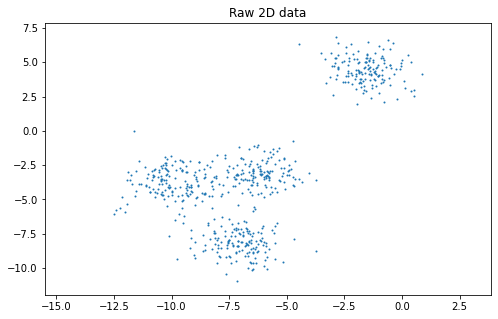

In [2]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

#To avoid the plt.show bug
%matplotlib inline

marge = 1
prop = 2

X, y = make_blobs(n_samples=600, centers=4, n_features=2, random_state=1)
# xlim_ = (np.min(X[:,0])-marge,np.max(X[:,0])+marge)
xlim_ = (np.min(X[:,0])-3,np.max(X[:,0])+3)
ylim_ = (np.min(X[:,1])-marge,np.max(X[:,1])+marge)
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],1)
plt.title('Raw 2D data')
plt.xlim(xlim_) 
plt.ylim(ylim_) 
plt.savefig('graph/tuto_KbMOM_step1_raw_data.png')
plt.show()
toggle_code()

<h1> </h1>

<h2 style="color: #888;font-style: italic;">A) Sampling_init</h2>

The first step in initialization is to create blocks with the *sampling_init* function.
It takes 3 hyperparameters: $B$ the number of blocks, $S$ their size and $K$ number of clusters to find.
On the following example, $B$=15 and $S$=20. We will explain later how to tune these values.  
(Note that the functions presented below have been simplified and adapted to the needs of the notebook)

In [3]:

import random
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

def sampling_init(X,B,S,K,random_state,n_local_trials=1):
        
        '''
        # Initialisation function: create nbr_blocks blocks, initialize with a kmeans++, compute a partition
        
        # X : dataset
        # B : number of blocks
        # s : number of data per block
        # K : number of clusters
        '''
        # variables that are only used in this tutorials to explain how it works
        all_blocks_before_clustering = []
        
            
        # body of code
        init_blocks = [0]*B
        
        # instanciation of kmeans++
        x_squared = X**2
        x_squared_norms = x_squared.sum(axis=1)
        
        # Blocks creation
        for i in range(B):
            idx = random.choices(np.arange(X.shape[0]),k = int(S))
            all_blocks_before_clustering.append(idx)
            kmeans_obj = KMeans(n_clusters=K, random_state=random_state, n_init=n_local_trials, init='k-means++')
            kmeans_obj.fit(X=X[idx,:])
            centers = kmeans_obj.cluster_centers_
            km_dist = cdist(X[idx,:],centers)
            km_labels_ = km_dist.argmin(axis=1)
            
            init_blocks[i] = [[j for j,x in zip(idx,km_labels_) if x==k] for k in range(K)]
            
        return init_blocks,all_blocks_before_clustering

In [4]:
K = 4
B = 15
S = 20

nb_columns = 5
nb_rows = 3
seed = 11061109
random.seed(seed)

<h2>

So, let's execute *sampling_init*

In [5]:
all_blocks_after_init_step, all_blocks_before_clustering = sampling_init(X,B=B,S=S,K=K,random_state=seed)

<h8>

For example, here's the 1st block

In [6]:
all_blocks_after_init_step[0]

[[396, 70, 597, 386, 306, 51],
 [308, 554, 562, 373, 40],
 [480, 150, 255, 281, 96],
 [313, 179, 498, 527]]

<h8>

Here's the 2nd block

In [7]:
all_blocks_after_init_step[1]

[[107, 91, 524, 9, 57, 474],
 [443, 28, 66, 24, 43],
 [111, 588, 11, 472, 430, 414],
 [372, 536, 279]]

<h8>

Here's the 8th block

In [8]:
all_blocks_after_init_step[7]

[[209, 107, 259, 431],
 [53, 529, 149, 149, 391, 450, 164, 45],
 [316, 219, 133],
 [69, 101, 234, 150, 524]]

<h2>

Now, let's display the plot of a block :

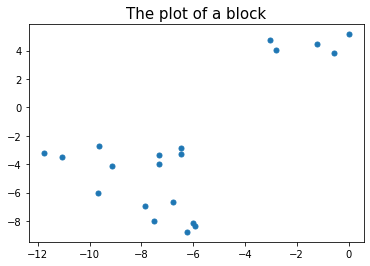

In [9]:
from matplotlib.cm import get_cmap

one_block_ = all_blocks_before_clustering[0]
# plt.figure(figsize=(8,5))
plt.plot(X[one_block_][:,0],X[one_block_][:,1],'.', markersize=10)
plt.title("The plot of a block",fontsize=15)
plt.show()
toggle_code()

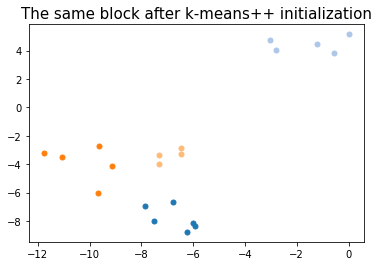

In [10]:
one_block_ = all_blocks_after_init_step[0]
cmap = get_cmap('tab20')
for cluster in range(K):
    colors = cmap((cluster))
    plt.plot(X[one_block_[cluster]][:,0],X[one_block_[cluster]][:,1],'.',c=colors, markersize=10)
    plt.title('The same block after k-means++ initialization',fontsize=15)
plt.show()
toggle_code()

<h2>

That was for a single block, but keep in mind that there are 15 of them:

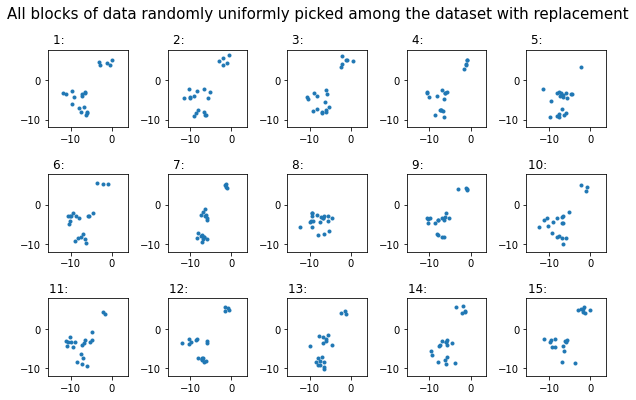

In [11]:
fig, axs = plt.subplots(nb_rows, nb_columns,figsize=(prop*5,prop*3))
for row in range(nb_rows):
    for column in range(nb_columns):
        one_block_ = all_blocks_before_clustering[column+row*nb_columns]
        axs[row,column].plot(X[one_block_][:,0],X[one_block_][:,1],'.')
        axs[row,column].set_xlim(xlim_)
        axs[row,column].set_ylim(ylim_)
        axs[row,column].set_title(str(column+row*nb_columns+1)+':               ')
        axs[row,column].set_xlim(xlim_) 
        axs[row,column].set_ylim(ylim_)
plt.subplots_adjust(wspace = 0.5,hspace = 0.6)
plt.suptitle('All blocks of data randomly uniformly picked among the dataset with replacement', fontsize=15)
plt.savefig('graph/tuto_KbMOM_step2_init_blocks')
plt.show()
toggle_code()

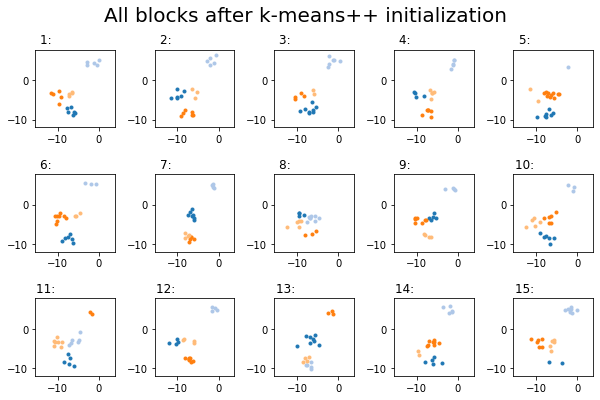

In [12]:
cmap = get_cmap('tab20')
fig, axs = plt.subplots(nb_rows, nb_columns,figsize=(prop*5,prop*3))
for row in range(nb_rows):
    for column in range(nb_columns):
        one_block_ = all_blocks_after_init_step[column+row*nb_columns]
        for cluster in range(K):
            colors = cmap((cluster))
            axs[row,column].plot(X[one_block_[cluster]][:,0],X[one_block_[cluster]][:,1],'.',c=colors)
            axs[row,column].set_xlim(xlim_)
            axs[row,column].set_ylim(ylim_)
            axs[row,column].set_title(str(column+row*nb_columns+1)+':               ')
plt.suptitle('All blocks after k-means++ initialization', fontsize=20)
plt.subplots_adjust(wspace = 0.5,hspace = 0.6)
plt.savefig('graph/tuto_KbMOM_step3_block_clustering')
plt.show()
toggle_code()

<h2>

<h2 style="color: #888;font-style: italic;">B) Qrisk</h2>

Then we will compute the risk for each block.<br>
First, the function *within_var*, computes the inertia of each cluster of a block

In [13]:
def within_var(one_block,X):
        '''
        # Function which returns a list of within inertia per cluster for the given block
        #      one_block : dictionnary of the subsample of one block according to the clusters
        '''
        n_b     = 0
        var_b   = [0]*K

        for key , val in enumerate(one_block): 
            X_block = X[val,:]
            var_b[key] = len(val)*np.sum(np.var(X_block,axis=0))/S

        return var_b

In [14]:
within_var(one_block_,X)

[0.23046722906471157,
 0.31298671791910315,
 0.45981505060761807,
 0.2702099634777766]

<h3>

Then, *Qrisk* computes the risk of each block and returns the block that got the median risk

In [15]:
quantile = 0.5 # this corresponds to taking the median

def Qrisk(all_blocks,X):
    '''
    # Function which computes the sum of all within variances and return:
            - Q_risk               = the q-quantile block risk
            - Q_id                 =  id of the associated q-quantile block
            - dict_within[Q_id]    = list of the within variances of the selected bloc
    ```parameters ```       
        . all_blocks : output of sampling_all_blocks
        . X          : matrix of datapoints
    '''

    dict_within = [0]*B
    Qb_risks = [0]*B


    for key, one_block_ in enumerate(all_blocks):
        dict_within[key] = within_var(one_block_,X)
        Qb_risks[key] = sum(dict_within[key])

    risks_argsort = np.argsort(np.array(Qb_risks),kind="mergesort")
    quantile_index = risks_argsort[round(quantile*B)-1]
    quantile_value = Qb_risks[quantile_index]
    return dict_within[quantile_index],all_blocks[quantile_index],quantile_index

<h4>

Let's take a look of all risks :

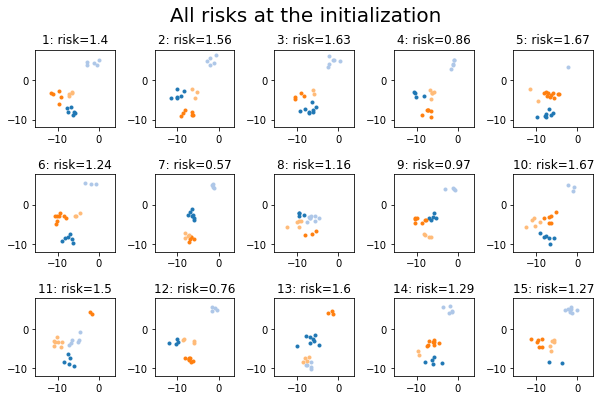

In [16]:
cmap = get_cmap('tab20')
fig, axs = plt.subplots(nb_rows, nb_columns,figsize=(prop*5,prop*3))
for row in range(nb_rows):
    for column in range(nb_columns):
        one_block_ = all_blocks_after_init_step[column+row*nb_columns]
        for cluster in range(K):
            colors = cmap((cluster))
            axs[row,column].plot(X[one_block_[cluster]][:,0],X[one_block_[cluster]][:,1],'.',c=colors)
            axs[row,column].set_title('{}: risk={}'.format(column+row*nb_columns+1,round(sum(within_var(all_blocks_after_init_step[column+row*nb_columns],X)),2)))
            axs[row,column].set_xlim(xlim_) 
            axs[row,column].set_ylim(ylim_)
plt.suptitle('All risks at the initialization', fontsize=20)
plt.subplots_adjust(wspace = 0.5,hspace = 0.6)
plt.savefig('graph/tuto_KbMOM_step4_block_risk')
plt.show()
toggle_code()

In [17]:
dict_within, Q_block, id_of_the_Q_block = Qrisk(all_blocks_after_init_step,X)
phrase = 'The {}th block was the one to achieve the median value of the risk among all blocks'
print(phrase.format(id_of_the_Q_block+1))
print('median risk = {}'.format(round(sum(dict_within),2)))
toggle_code()

The 14th block was the one to achieve the median value of the risk among all blocks
median risk = 1.29


We can also see that the 8th block is an occurence of an unlikely event : no data from the cluster on the top right has been picked contrary to the other clusters  
(as you can see on the plot below).

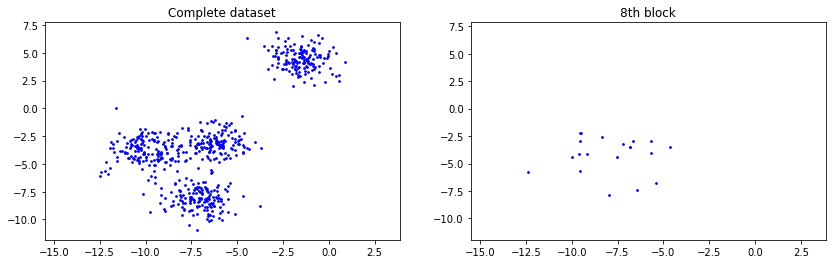

In [18]:
block_ = all_blocks_after_init_step[7]

fig = plt.figure(figsize=(prop*7,prop*2))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharex=ax1)

ax1.scatter(X[:,0],X[:,1],3,c="Blue")
ax1.set_title('Complete dataset')
   
for cluster in block_:
    ax2.scatter(X[cluster][:,0],X[cluster][:,1],3,c="Blue")
    ax2.set_title('8th block')
    

plt.ylim(ylim_)
plt.xlim(xlim_)
plt.suptitle('', fontsize=20)
plt.show()
toggle_code()

Fortunately, this kind of particular cases will not be retained because their risk will not be median.

<h8>

Let's plot the median block :

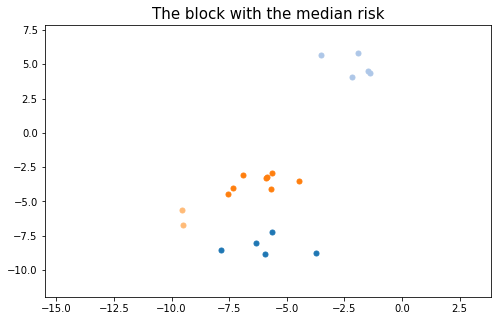

In [19]:
cmap = get_cmap('tab20')
plt.subplots(figsize=(8,5))
for cluster in range(K):
    colors = cmap((cluster))
    plt.plot(X[Q_block[cluster]][:,0], X[Q_block[cluster]][:,1], '.', c=colors, markersize=10)
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    plt.title('The block with the median risk',fontsize=15)
plt.savefig('graph/tuto_KbMOM_step5_init_median_block')
plt.show()
toggle_code()

In [20]:
def Qb_centers(Q_block,X):
    '''
    #compute the mean vector of each cluster in the q-quantile block and return it
    '''
    centers_ = []
    for k in range(K):
        center_k = X[Q_block[k],:].mean(axis=0)
        centers_.append(center_k)
    return np.array(centers_)

The function above enable us to plot the centers of each cluster on top of the sample

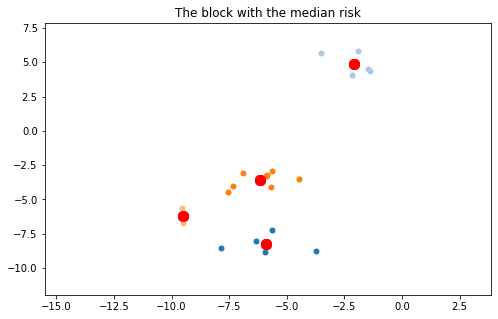

In [21]:
centers = Qb_centers(Q_block,X)

cmap = get_cmap('tab20')
plt.subplots(figsize=(8,5))
for cluster in range(K):
    colors = cmap((cluster))
    plt.plot(X[Q_block[cluster]][:,0], X[Q_block[cluster]][:,1], '.', c=colors, markersize=10)
    plt.plot(centers[:,0], centers[:,1], '.', c="red", markersize=20)
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    plt.title('The block with the median risk')
plt.savefig('graph/tuto_KbMOM_step5_init_median_block_plus_centers')
plt.show()
toggle_code()

<h2>

<h2 style="color: #888;font-style: italic;">C) Update_loop</h2>

At this point, initialization is almost complete.  All we have to do now is to determine the centers and the partition.  
The *update_loop* function (which we'll talk about later) takes care of finalization.

In [22]:
def update_loop(X,Qb):
    '''
    # Qb    : Q-quantile block
    # Q_block_list_of_within_var : within inertia of the qq block
    '''
    # updates centers
    centers = Qb_centers(Qb,X)

    # retrieve partition of data
    D_nk = cdist(XA=X,XB=centers)
    partition_array = D_nk.argmin(axis=1)
    partition_list = []
    for k in range(K):
        partition_list.append(np.where(partition_array == k)[0].tolist())
        
    # compute empirical risk
    D_nk_min_rows = D_nk[[np.arange(X.shape[0]).tolist(),partition_array.tolist()]]

    return centers, partition_array,partition_list

In [23]:
centers, partition,partition_list = update_loop(X,Q_block)

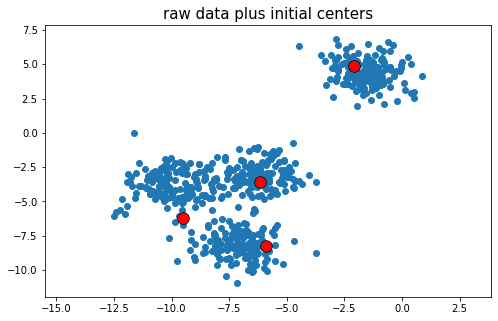

In [24]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1])
plt.scatter(centers[:,0],centers[:,1],s=130,color="black")
plt.scatter(centers[:,0],centers[:,1],s=100,color="red")
plt.title("raw data plus initial centers", fontsize=15)
plt.xlim(xlim_)
plt.ylim(ylim_)
plt.savefig('graph/tuto_KbMOM_step5_init_raw_data_plus_centers')
plt.show()
toggle_code()

<h2>

That's it, the initialization is complete, let's display the result:

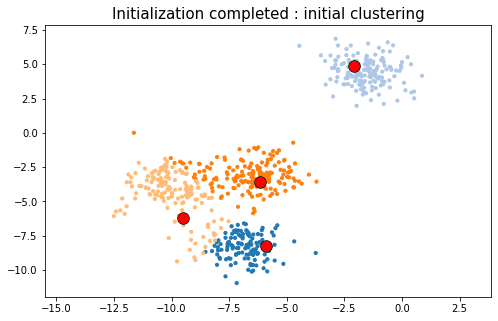

In [25]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],10,color=plt.get_cmap('tab20')(partition))
plt.scatter(centers[:,0],centers[:,1],s=130,color="black")
plt.scatter(centers[:,0],centers[:,1],s=100,color="red")
plt.title("Initialization completed : initial clustering", fontsize=15)
plt.xlim(xlim_)
plt.ylim(ylim_)
plt.savefig('graph/tuto_KbMOM_step6_init_completed')
plt.show()
toggle_code()

<h8>

Below is the initialization code present in the K-bMOM class :

In [26]:
def initialisation_without_init_centers(self,X):
    # Initialisation step : initialisation per block: sampling B blocks and init via kmeans++
    init_blocks = self.sampling_init(X)

    # compute empirical risk among blocks and select the Q-quantile-block
    Q_within, Q_b = self.Qrisk(init_blocks,X)

    # update all the global variables
    self.update_loop(X,Q_b,Q_within)

    # save results
    self.id_Qblock_init = Q_b
    #self.res_Qb_risk.append(Q_risk)

<h2></h2><hr style="width:100%; border-top: 3px solid #888;"><h1>

<h2 id="2.-How-to-choose-$B$-and-$S$" style="color: #666; font-size:30px;">2. How to choose $B$ and $S$</h2>

Just before cell *In [3]*, we told you that we were going to explain how to find the $B$ and $S$ values.<br>
They are calculated using mathematical equations.

In [27]:
from math import log, ceil, floor, inf

def block_size_max(n_sample,n_outliers):
    '''
    Function which fits the maximum size of blocks before a the breakpoint
    ```prms```
    n_sample: nb of data
    n_outlier: nb of outliers
    '''
    if n_outliers == 0:
        bloc_size_max = inf
    else:
        bloc_size_max = log(2.)/log(1/(1- (n_outliers/n_sample)))
    return floor(bloc_size_max)

def minimal_number_of_blocks(n_sample,n_outliers,b_size=None,alpha=0.05):
    '''
    Function which fits the minimum nb of blocks for a given size t before a the breakpoint
    ```prms```
    n_sample: nb of data
    n_outlier: nb of outliers
    b_size = bloc_size
    alpha : threshold confiance
    '''
    if n_outliers/n_sample >= 0.5:
        print('too much noise')
        return()
    else:
        if n_outliers == 0 :
            return 1
        elif b_size is None:
            t = bloc_size(n_sample,n_outliers)
        else:
            t = b_size
    
    bloc_nb_min = log(1/alpha) / (2* ((1-n_outliers/n_sample)**t - 1/2)**2)
    return ceil(bloc_nb_min)

First you have to choose the size of the blocks, then the number of blocks. We realize that the bigger the size of a block is, the bigger the number of blocks must be, so in order to avoid too much complexity, it is better to choose a block size smaller than the maximum allowed. <br><br>Look at the curve below to see how $B$ behaves as $S$  grows.

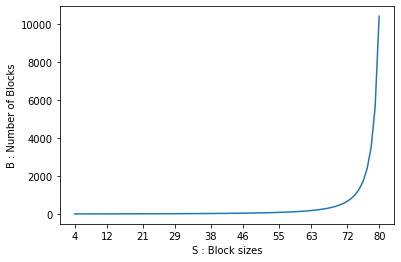

In [28]:
S = block_size_max(n_sample=600,n_outliers=5)

list_block_size = []
list_nb_blocks = []
abscisse = np.round(np.linspace(K,S-2,100))
ticks = np.round(np.linspace(K,S-2,10))
if S < inf:
    for k in abscisse:
        list_block_size = list_block_size + [k]
        list_nb_blocks = list_nb_blocks + [
            minimal_number_of_blocks(n_sample=600,n_outliers=5,b_size=k,alpha=0.05)
        ]
    plt.plot(list_block_size,list_nb_blocks)
    plt.xticks(ticks)
    plt.xlabel('S : Block sizes')
    plt.ylabel('B : Number of Blocks')
    plt.show()
toggle_code()

In [29]:
block_size_max(n_sample=600,n_outliers=5)

82

(Please note that the parameter *n_outliers*, is actually an estimated majoration of the amount of outliers in your dataset) <br><br>
The maximum size of a block should be 82, but as you have understood, we will take a lower value.<br>
In this case you can take $S$ equal to 60. (For our example we used $S$=20 for pedagogical reasons)

In [30]:
minimal_number_of_blocks(n_sample=600,n_outliers=5, b_size=20)

13

Now you can run *minimal_number_of_blocks*. 13 is the minimum value you can use, and that's why we chose $B$=15 in our previous example.

<h2></h2><hr style="width:100%; border-top: 3px solid #888;"><h1>

<h2 id="3.-Iteration" style="color: #666; font-size:30px;">3. Iteration</h2>

In reality, the iterations are very close to the initialization process.

***Input :*** the dataset $\{x_1, . . . , x_n\}$, $B$ the number of blocks and $S$ size of blocks ($S$>$K$)  
<br>
***Main Loop :*** WHILE the $stop Criterion$ isn't reached or $iter$ < $iter$<sub>max</sub>:

>1. Create $B$ blocks of the data of size $S$ randomly and uniformly with replacement  
>2. In each block, assign each datapoint to its closest centroid. 
>
>3. Keep the block with the median empirical risk  
>4. Calculate the new centers

***Output :*** Partition

A CHOISIR

***Input :*** the dataset $\{x_1, . . . , x_n\}$, $B$ the number of blocks and $S$ size of blocks ($S$>$K$)  
<br>
***Main Loop :*** WHILE the $stop Criterion$ isn't reached or $iter$ < $iter$<sub>max</sub>:

>1. Iterate from 1 until $B$ blocks : 
>> • Create a block with size $S$ randomly and uniformly with replacement  
>> • Assign each datapoint to its closest centroid. 
>
>3. Keep the block with the median empirical risk  
>4. Compute the new centers

***Output :*** Partition

<h2>

The only major difference is the construction of the blocks.  
They are built using the *sampling_all_blocks* function which is very close to *sampling_init*.  
However, thanks to the *nb_min_repr_by_cluster* parameter, each cluster in each block will have at least *nb_min_repr_by_cluster* data. This value is set to 1 by default.

<h3 id="i-draw-random-blocks" style="color: #666; font-size:20px;">i. Draw random blocks</h3>

In [31]:
def sampling_all_blocks(X,partition,B,S,nb_min_repr_by_cluster=1):#,nbr_blocks,weighted_point,cluster_sizes):
    '''
    # Function which creates nbr_blocks blocks conditionally to the partition_dict and return a dictionary 
    # per block of the ids of selected  data per cluster and per bloc
    #  
    #     nbr_blocks      : number of blocks to be created
    #     weighted_point : a dictonnary of clusters containing the lists of weights
    #     cluster_sizes   : vector containing the size of each clusters
    '''
    dict_blocks = [0]*B
    for i in range(B):
        # to ensure there are K categories in each block run that part, one can go through the first piece of code, else run 'else'
        list_of_points = []
        if nb_min_repr_by_cluster > 0:
            for k in range(K):
                indexes = np.where(partition == k)[0]
                list_of_points = list_of_points + random.choices(indexes, k=nb_min_repr_by_cluster)
#                 print(list_of_points)
#             print(S-nb_min_repr_by_cluster*K)
            idx_indep = random.choices(np.arange(X.shape[0]), k=S-nb_min_repr_by_cluster*K)
#             print(idx_indep)
        else:
            idx_indep = random.choices(np.arange(X.shape[0]), k=S)
        idx = list_of_points + idx_indep

        km_dist    = cdist(X[idx,:],centers)
        km_labels_ = km_dist.argmin(axis=1)         
        dict_blocks[i] = [[j for j,x in zip(idx,km_labels_) if x==k] for k in range(K)]

    return dict_blocks

In [32]:
B = 15
S = 20

In [33]:
all_blocks_iter_1 = sampling_all_blocks(X,partition=partition,B=B,S=S,nb_min_repr_by_cluster=1)


In [34]:
all_blocks_iter_1[0]

[[172, 335, 232, 264, 240, 249],
 [177, 355, 246],
 [80, 38, 45, 72, 75],
 [231, 265, 265, 48, 304, 328]]

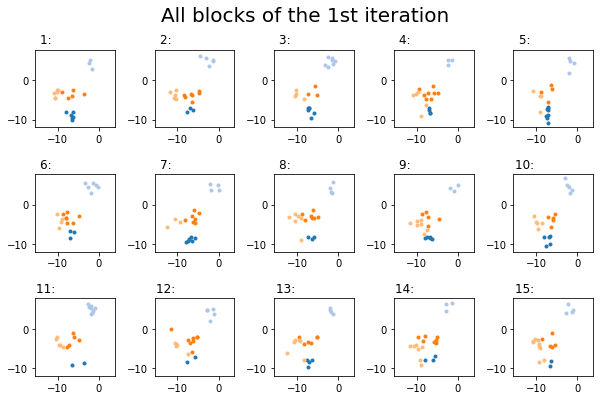

In [35]:
cmap = get_cmap('tab20')
fig, axs = plt.subplots(nb_rows, nb_columns,figsize=(prop*5,prop*3))
for row in range(nb_rows):
    for column in range(nb_columns):
        one_block_ = all_blocks_iter_1[column+row*nb_columns]
        for cluster in range(K):
            colors = cmap((cluster))
            axs[row,column].plot(X[one_block_[cluster]][:,0],X[one_block_[cluster]][:,1],'.',c=colors)
            axs[row,column].set_xlim(xlim_)
            axs[row,column].set_ylim(ylim_)
            axs[row,column].set_title(str(column+row*nb_columns+1)+':               ')
plt.suptitle('All blocks of the 1st iteration', fontsize=20)
plt.subplots_adjust(wspace = 0.5,hspace = 0.6)
plt.savefig('graph/tuto_KbMOM_step7_blocks_1st_iter')
plt.show()
# toggle_code()

<h3 id="ii-compute-risks" style="color: #666; font-size:20px;">ii. Compute risks</h3>

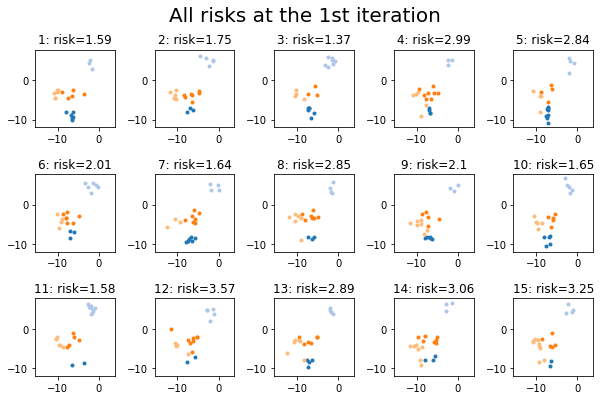

In [36]:
cmap = get_cmap('tab20')
fig, axs = plt.subplots(nb_rows, nb_columns,figsize=(prop*5,prop*3))
xlim_ = (np.min(X[:,0])-3,np.max(X[:,0])+3)
for row in range(nb_rows):
    for column in range(nb_columns):
        one_block_ = all_blocks_iter_1[column+row*nb_columns]
        for cluster in range(K):
            colors = cmap((cluster))
            axs[row,column].plot(X[one_block_[cluster]][:,0],X[one_block_[cluster]][:,1],'.',c=colors)
            axs[row,column].set_title('{}: risk={}'.format(column+row*nb_columns+1,round(sum(within_var(all_blocks_iter_1[column+row*nb_columns],X)),2)))
            axs[row,column].set_xlim(xlim_)
            axs[row,column].set_ylim(ylim_)
plt.suptitle('All risks at the 1st iteration', fontsize=20)
plt.subplots_adjust(wspace = 0.5,hspace = 0.6)
plt.savefig('graph/tuto_KbMOM_step8_risks_1st_iter')
plt.show()
# toggle_code()

<h3 id="iii-take-the-block-with-risk" style="color: #666; font-size:20px;">iii. Take the block with median risk</h3>

In [37]:
dict_within, Q_block, id_of_the_Q_block = Qrisk(all_blocks_iter_1,X)
phrase = 'The {}th block was the one to achieve the median value of the risk among all blocks'
print(phrase.format(id_of_the_Q_block+1))
print('median risk = {}'.format(round(sum(dict_within),2)))
toggle_code()

The 9th block was the one to achieve the median value of the risk among all blocks
median risk = 2.1


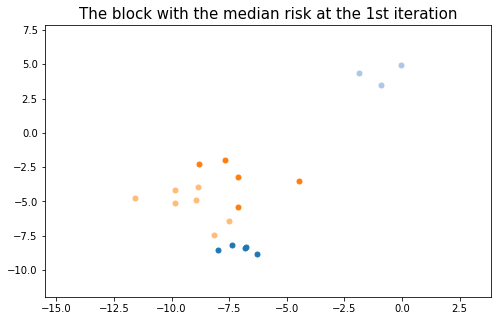

In [38]:
cmap = get_cmap('tab20')
plt.subplots(figsize=(8,5))
for cluster in range(K):
    colors = cmap((cluster))
    plt.plot(X[Q_block[cluster]][:,0], X[Q_block[cluster]][:,1], '.', c=colors, markersize=10)
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    plt.title('The block with the median risk at the 1st iteration',fontsize=15)
plt.savefig('graph/tuto_KbMOM_step9_1st_iter_median_block')
plt.show()
# toggle_code()

<h3 id="iv-compute-centers-1st-iter" style="color: #666; font-size:20px;">iii. compute news centers of 1st iteration</h3>

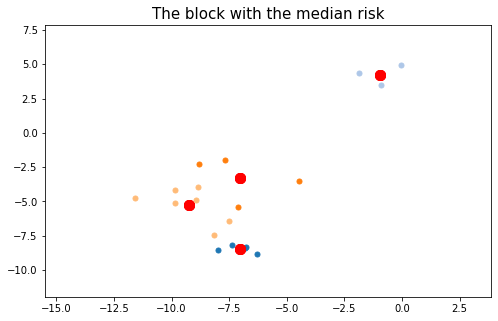

In [39]:
# centers = Qb_centers(Q_block,X)
centers, partition,partition_list = update_loop(X,Q_block)

cmap = get_cmap('tab20')
plt.subplots(figsize=(8,5))
for cluster in range(K):
    colors = cmap((cluster))
    plt.plot(X[Q_block[cluster]][:,0], X[Q_block[cluster]][:,1], '.', c=colors, markersize=10)
    plt.plot(centers[:,0], centers[:,1], '.', c="red", markersize=20)
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    plt.title('The block with the median risk',fontsize=15)
plt.savefig('graph/tuto_KbMOM_step9_1st_iter_median_block_plus_centers')
plt.show()
toggle_code()

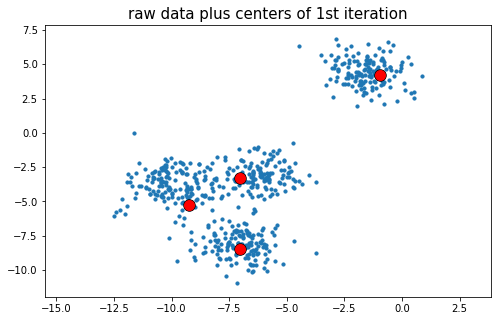

In [40]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],10)
plt.scatter(centers[:,0],centers[:,1],s=130,color="black")
plt.scatter(centers[:,0],centers[:,1],s=100,color="red")
plt.title("raw data plus centers of 1st iteration", fontsize=15)
plt.xlim(xlim_)
plt.ylim(ylim_)
plt.savefig('graph/tuto_KbMOM_step9_1st_iter_raw_data_plus_centers')
plt.show()
toggle_code()

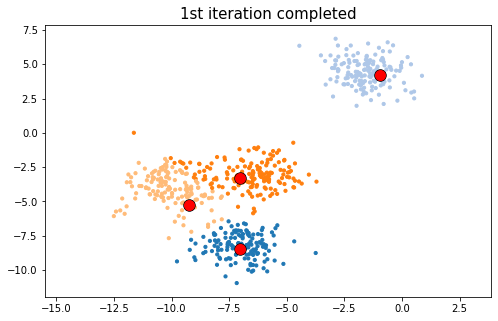

In [41]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],10,color=plt.get_cmap('tab20')(partition))
plt.scatter(centers[:,0],centers[:,1],s=130,color="black")
plt.scatter(centers[:,0],centers[:,1],s=100,color="red")
plt.title("1st iteration completed", fontsize=15)
plt.xlim(xlim_)
plt.ylim(ylim_)
plt.savefig('graph/tuto_KbMOM_step10_1st_iter_completed')
plt.show()
toggle_code()

Etc...

From this step, one just need to follow the process of the 1st iteration to run the 2nd one.

<h1>

<h1>

<h1 id="Use-of-K-bMOM" style="text-decoration:underline; font-size:35px;">Use of K-bMOM</h1>

In [42]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

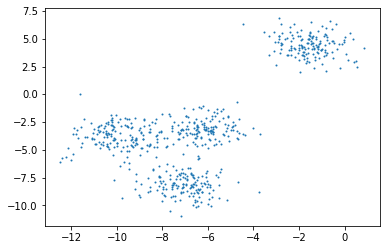

In [43]:
import numpy as np
from RobustClustering import KbMOM # KbMOM stands for K-bootstrap Median-Of-Means
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

#To avoid the plt.show bug
%matplotlib inline

X, y = make_blobs(n_samples=600, centers=4, n_features=2, random_state=1)
plt.scatter(X[:,0],X[:,1],1)
plt.show()

<h2 id="Launch-KbMOM" style="color: #666; font-size:30px;">1. Launch K-bMOM</h2>

In [44]:
instance_KbMOM = KbMOM(K=4,X=X,block_size=20,number_of_blocks=15,nb_min_repr_by_cluster=1)

In [45]:
results_KbMOM = instance_KbMOM.fit(X=X)

In [46]:
results_KbMOM

{'centroids': array([[ -0.96112028,   3.99386367],
        [ -6.46978343,  -8.58507259],
        [-10.36724746,  -4.22438314],
        [ -5.62983653,  -3.00919503]]),
 'labels': array([1, 3, 1, 2, 0, 3, 3, 0, 3, 2, 0, 1, 3, 3, 0, 0, 2, 1, 0, 0, 1, 2,
        0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0, 2, 1, 3, 3, 0, 0, 1, 0,
        0, 3, 2, 0, 2, 0, 3, 1, 3, 3, 3, 1, 0, 2, 0, 2, 2, 2, 1, 2, 1, 3,
        0, 0, 2, 2, 1, 3, 3, 1, 1, 3, 1, 1, 0, 1, 2, 2, 1, 0, 3, 2, 2, 1,
        0, 2, 0, 2, 3, 3, 1, 2, 2, 2, 0, 1, 2, 2, 3, 0, 2, 3, 1, 2, 0, 2,
        2, 1, 0, 2, 1, 3, 1, 0, 0, 2, 0, 2, 2, 0, 3, 3, 3, 1, 3, 3, 2, 1,
        1, 1, 1, 3, 3, 2, 0, 0, 3, 3, 1, 2, 0, 0, 1, 3, 0, 3, 2, 3, 2, 3,
        1, 1, 2, 2, 2, 1, 2, 0, 2, 3, 3, 0, 0, 1, 2, 1, 0, 2, 1, 2, 2, 1,
        1, 0, 0, 3, 0, 1, 2, 1, 2, 2, 2, 1, 2, 3, 0, 0, 0, 1, 3, 1, 0, 3,
        0, 2, 0, 1, 0, 0, 1, 2, 1, 0, 1, 2, 1, 2, 0, 0, 1, 3, 0, 3, 3, 1,
        1, 3, 3, 2, 0, 2, 1, 2, 2, 1, 1, 2, 1, 3, 2, 0, 0, 1, 3, 3, 1, 2,
        2

<h2 id="Review-all-information-in-K-bMOM-output" style="color: #666; font-size:30px;">2. Review all information in K-bMOM output</h2>

In [47]:
output_keys = results_KbMOM.keys()
output_keys

dict_keys(['centroids', 'labels', 'clusters_composition', 'q_quantile_block_at_initialization', 'convergence', 'data_depth', 'all_data_risks', 'quantile_block_risks', 'list_of_all_quantile_block_centers_through_iterations', 'number_of_blocks', 'block_size', 'n_iter'])

<h3 id="centroids" style="color: #666; font-size:25px;">- centroids</h3>

centroids are the k vectors that represent each cluster

In [48]:
centroids = results_KbMOM['centroids']
centroids

array([[ -0.96112028,   3.99386367],
       [ -6.46978343,  -8.58507259],
       [-10.36724746,  -4.22438314],
       [ -5.62983653,  -3.00919503]])

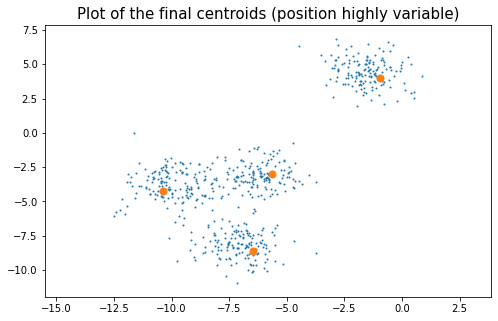

In [49]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],1)
plt.scatter(centroids[:,0],centroids[:,1],color=plt.get_cmap('tab10')(1),s=50)
plt.title('Plot of the final centroids (position highly variable)',fontsize=15)
plt.xlim(xlim_) 
plt.ylim(ylim_) 
plt.savefig('graph/tuto_KbMOM_step20_final_centroids')
plt.show()

<h3 id="labels" style="color: #666; font-size:25px;">- labels</h3>

labels are the n integers that inform which cluster a datapoint belongs to

In [50]:
labels = results_KbMOM['labels']
labels

array([1, 3, 1, 2, 0, 3, 3, 0, 3, 2, 0, 1, 3, 3, 0, 0, 2, 1, 0, 0, 1, 2,
       0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0, 2, 1, 3, 3, 0, 0, 1, 0,
       0, 3, 2, 0, 2, 0, 3, 1, 3, 3, 3, 1, 0, 2, 0, 2, 2, 2, 1, 2, 1, 3,
       0, 0, 2, 2, 1, 3, 3, 1, 1, 3, 1, 1, 0, 1, 2, 2, 1, 0, 3, 2, 2, 1,
       0, 2, 0, 2, 3, 3, 1, 2, 2, 2, 0, 1, 2, 2, 3, 0, 2, 3, 1, 2, 0, 2,
       2, 1, 0, 2, 1, 3, 1, 0, 0, 2, 0, 2, 2, 0, 3, 3, 3, 1, 3, 3, 2, 1,
       1, 1, 1, 3, 3, 2, 0, 0, 3, 3, 1, 2, 0, 0, 1, 3, 0, 3, 2, 3, 2, 3,
       1, 1, 2, 2, 2, 1, 2, 0, 2, 3, 3, 0, 0, 1, 2, 1, 0, 2, 1, 2, 2, 1,
       1, 0, 0, 3, 0, 1, 2, 1, 2, 2, 2, 1, 2, 3, 0, 0, 0, 1, 3, 1, 0, 3,
       0, 2, 0, 1, 0, 0, 1, 2, 1, 0, 1, 2, 1, 2, 0, 0, 1, 3, 0, 3, 3, 1,
       1, 3, 3, 2, 0, 2, 1, 2, 2, 1, 1, 2, 1, 3, 2, 0, 0, 1, 3, 3, 1, 2,
       2, 2, 2, 1, 0, 3, 2, 1, 2, 3, 2, 1, 3, 2, 2, 1, 0, 2, 0, 0, 3, 3,
       1, 2, 0, 1, 3, 0, 3, 2, 2, 0, 3, 0, 1, 2, 3, 3, 0, 2, 1, 2, 1, 2,
       1, 0, 0, 0, 0, 2, 3, 1, 0, 1, 2, 3, 3, 0, 1,

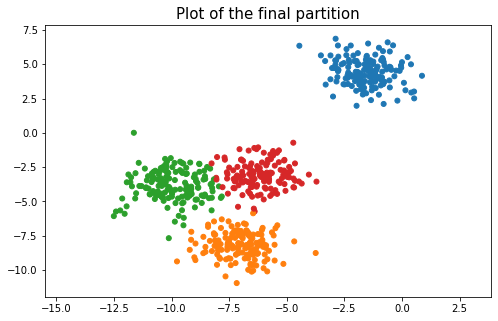

In [51]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],color=plt.get_cmap('tab10')(labels),s=25)
plt.title('Plot of the final partition',fontsize=15)
plt.xlim(xlim_) 
plt.ylim(ylim_) 
plt.savefig('graph/tuto_KbMOM_step21_final_labels')
plt.show()

<h3 id="q_quantile_block_at_initialization" style="color: #666; font-size:25px;">- q_quantile_block_at_initialization</h3>

q_quantile_block_at_initialization is the composition of the initial block that achieved the median value of the empirical risk among all blocks.

It is possible to take another quantile.

In [54]:
results_KbMOM['q_quantile_block_at_initialization']

[[41, 22, 477],
 [442, 565, 588, 193, 253, 462, 181, 94],
 [119, 281, 567, 61],
 [549, 1, 376, 571, 325]]

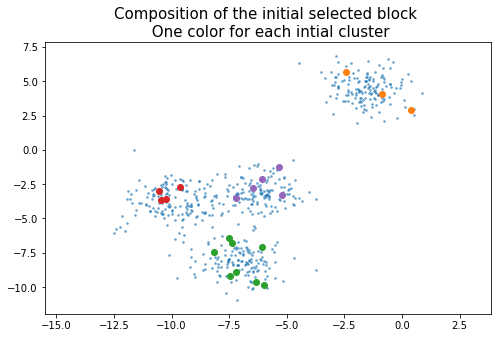

In [56]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],s=3,alpha=0.5)
for num,cluster_sample in enumerate(results_KbMOM['q_quantile_block_at_initialization']):
    plt.scatter(X[cluster_sample,0],X[cluster_sample,1],color=plt.get_cmap('tab10')(num+1))
plt.title('Composition of the initial selected block \n One color for each intial cluster',fontsize=15)
plt.xlim(xlim_) 
plt.ylim(ylim_) 
plt.savefig('graph/tuto_KbMOM_step22_id_Qblock_init')
plt.show()

<h3 id="convergence" style="color: #666; font-size:25px;">- convergence</h3>

convergence returns the list of all Aitkens criterion values. The first 2 values are None because Aitkens is based on the two previous quantities.

In [57]:
results_KbMOM['convergence']

[None, None]

<h3 id="data_depth" style="color: #666; font-size:25px;">- data_depth</h3>

scores are the quantities that mimics a data depth. The lower the score of a datapoint, the further from all centroids along all iterations, the more the datapoint is an outlier in its cluster.

In [59]:
data_depth = results_KbMOM['data_depth']
np.round(data_depth,2)

array([2.15, 6.81, 3.72, 6.24, 4.14, 5.52, 4.5 , 3.94, 5.39, 4.81, 6.21,
       4.84, 4.76, 7.03, 3.42, 3.61, 4.74, 5.49, 6.06, 3.98, 3.61, 4.85,
       3.65, 7.63, 3.74, 3.01, 6.51, 5.16, 0.65, 6.24, 4.36, 3.36, 3.94,
       2.5 , 4.51, 3.5 , 0.96, 5.56, 1.45, 2.48, 2.37, 2.41, 3.51, 4.83,
       4.07, 4.53, 5.1 , 4.66, 3.91, 5.25, 5.16, 5.93, 3.79, 5.69, 2.93,
       3.29, 6.31, 6.05, 5.36, 6.88, 3.77, 7.45, 4.19, 5.06, 0.94, 4.17,
       7.68, 5.47, 4.72, 2.08, 6.36, 5.99, 6.52, 6.35, 5.2 , 4.7 , 3.38,
       4.46, 5.19, 3.68, 5.32, 5.95, 0.58, 6.67, 5.46, 3.96, 5.13, 7.08,
       5.26, 4.75, 5.73, 3.05, 4.96, 3.94, 2.37, 5.26, 2.74, 5.18, 0.63,
       5.85, 6.6 , 5.28, 1.34, 2.63, 4.37, 5.24, 6.06, 4.03, 1.3 , 5.38,
       3.71, 5.74, 3.38, 4.26, 4.67, 1.61, 5.97, 3.03, 4.75, 7.43, 5.84,
       6.24, 4.27, 2.23, 2.96, 6.68, 2.02, 7.55, 3.81, 3.22, 5.24, 6.29,
       4.68, 5.41, 2.02, 3.4 , 5.81, 5.83, 5.5 , 2.39, 3.53, 6.49, 2.93,
       5.26, 3.58, 5.34, 1.46, 1.45, 5.62, 7.01, 6.

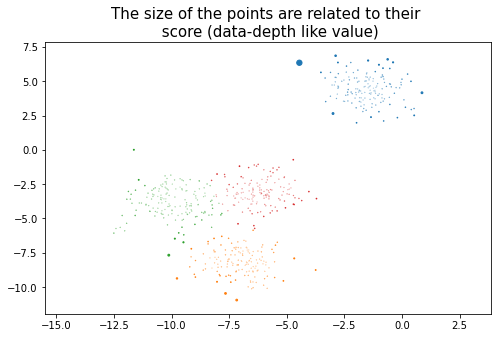

In [60]:
# as shown on the plot, the greatest datapoints are the point whose scores are lowest
# and it seems to coincide with a data depth
# warning /!\ the sizes on the plot are not proportionnal to scores
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],color=plt.get_cmap('tab10')(labels),s=1/data_depth**2)
plt.title('The size of the points are related to their \n score (data-depth like value)',fontsize=15)
plt.xlim(xlim_) 
plt.ylim(ylim_) 
plt.savefig('graph/tuto_KbMOM_step23_scores')
plt.show()

<h3 id="quantile_block_risks" style="color: #666; font-size:25px;">- quantile_block_risks</h3>

Qb_risk is the list of all values encountered for the median risk throughout iterations.

As one can see, the risk of the median bloc is not monotonous. The algorithm has though good empirical performances (Qb_block stands for "quantile block" because one can choose another quantile than median)

In [62]:
results_KbMOM['quantile_block_risks']

[1.6178142322418185,
 1.391795535318245,
 1.2997954581781586,
 1.5230717369962492,
 1.6008844802495736,
 1.5380161885887407,
 1.3399399296468775,
 1.6571651683478144,
 1.607716047866673,
 1.6321138186200055,
 1.3389551203759305,
 1.4193114677140026,
 1.424197198773201,
 1.5637037489174965,
 1.3160914007761706,
 1.3258915226080137,
 1.4066617492120708,
 1.4928000574659257,
 1.4279827920182717,
 1.1412002860139516,
 1.3789658810215235]

<h3 id="list_of_all_quantile_block_centers_through_iterations" style="color: #666; font-size:25px;">- list_of_all_quantile_block_centers_through_iterations</h3>

list_of_all_quantile_block_centers_through_iterations is simply the list of all sets of centroids encountered at each steps of the algorithm

It is possible to take another quantile.

In [63]:
list_of_all_quantile_block_centers_through_iterations = results_KbMOM['list_of_all_quantile_block_centers_through_iterations']
list_of_all_quantile_block_centers_through_iterations

[array([[ -0.95742275,   4.20891417],
        [ -7.01484637,  -8.16757387],
        [-10.2187541 ,  -3.23377093],
        [ -6.06349253,  -2.60598985]]),
 array([[ -1.23317847,   4.30366316],
        [ -6.43305199,  -8.17075641],
        [-10.57632588,  -3.84228156],
        [ -6.33979096,  -2.65255803]]),
 array([[ -1.62003313,   3.90455062],
        [ -7.91868501,  -7.93332619],
        [-10.5001773 ,  -3.86943686],
        [ -6.46458494,  -2.93276568]]),
 array([[ -2.36447065,   4.51819163],
        [ -7.00106066,  -8.20723042],
        [-10.33467468,  -3.28183186],
        [ -5.79696188,  -2.79009768]]),
 array([[-1.5126929 ,  4.87933737],
        [-7.14496776, -8.38484864],
        [-9.68314847, -3.43532055],
        [-6.36791589, -3.31141543]]),
 array([[ -1.42760931,   3.9811232 ],
        [ -6.4094443 ,  -8.54925066],
        [-10.4003439 ,  -4.51363219],
        [ -6.35386945,  -3.68570864]]),
 array([[-1.41376327,  4.6864708 ],
        [-7.37208207, -8.14297423],
        [-9.

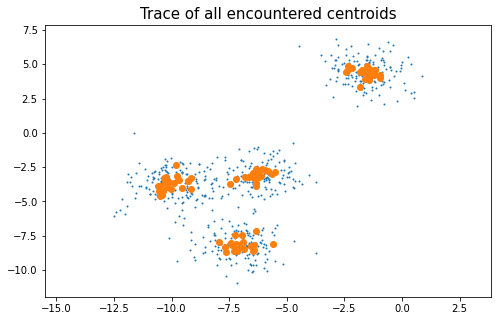

In [64]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],1)
for num,centroids in enumerate(list_of_all_quantile_block_centers_through_iterations):
    plt.scatter(centroids[:,0],centroids[:,1],color=plt.get_cmap('tab10')(1))
plt.title('Trace of all encountered centroids',fontsize=15)
plt.xlim(xlim_) 
plt.ylim(ylim_) 
plt.savefig('graph/tuto_KbMOM_step24_Qb_centers')
plt.show()

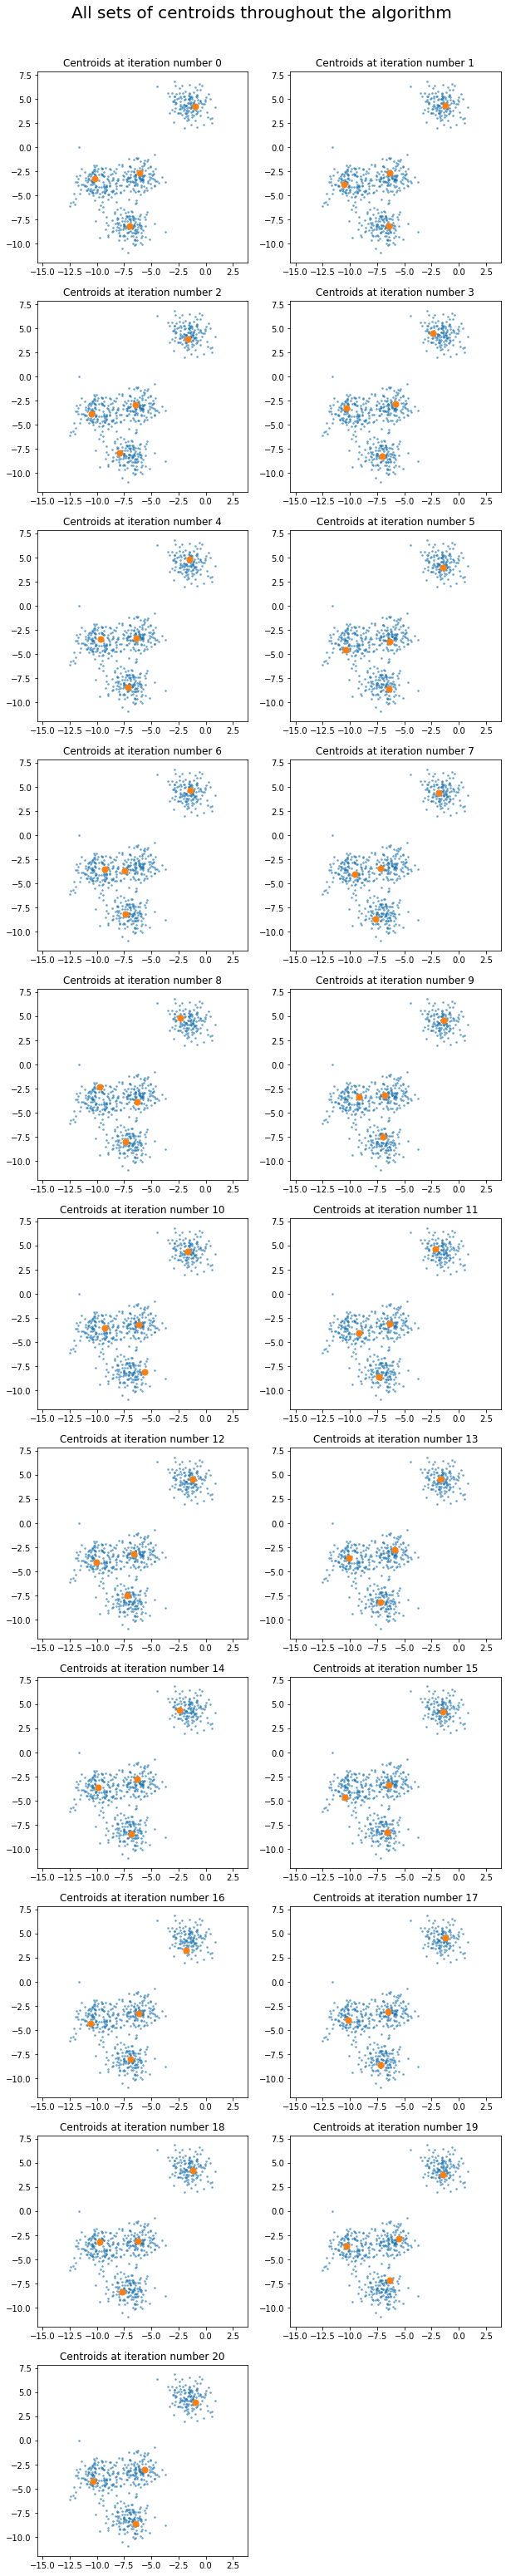

In [65]:
ncols=2
nb_graphs = len(list_of_all_quantile_block_centers_through_iterations)
nrows=int(nb_graphs/ncols+1)
size_1_plot = 5

fig,axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(size_1_plot*ncols,size_1_plot*nrows ))
for num,centroids in enumerate(list_of_all_quantile_block_centers_through_iterations):
    axes[int(num/ncols),num%ncols].scatter(X[:,0],X[:,1],s=3,alpha=0.5)
    axes[int(num/ncols),num%ncols].scatter(centroids[:,0],centroids[:,1],color=plt.get_cmap('tab10')(1),s=50)
    axes[int(num/ncols),num%ncols].set_title(f'Centroids at iteration number {num}')
    axes[int(num/ncols),num%ncols].set_xlim(xlim_) 
    axes[int(num/ncols),num%ncols].set_ylim(ylim_) 
for num_graph in range(ncols*nrows):
    if nb_graphs <= num_graph:
        axes[int(num_graph/ncols),num_graph%ncols].axis('off')
st = fig.suptitle('All sets of centroids throughout the algorithm', fontsize=20)
st.set_y(0.9)
plt.show()

<h3 id="B" style="color: #666; font-size:25px;">- B</h3>

B is the number of block created a each step of the algorithm

In [66]:
results_KbMOM['number_of_blocks']

15

<h3 id="t" style="color: #666; font-size:25px;">- t</h3>

t is the size of all created blocks

In [67]:
results_KbMOM['block_size']

20